# Feedforward Neural Network in TF
Using framework from modular-basic-nn.ipynb but using TF instead of numpy--higher-level abstraction.

In [1]:
# Carter Brown
# Created: June 6, 2017
# Modifyd: June 6, 2017
# to see some pictures, go to very bottom
# generally much faster than modular-basic-nn.ipynb

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf
import sklearn
import sklearn.datasets
import sklearn.linear_model

In [3]:
# Display plots inline and change default figure size
%pylab inline
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# print debug statements
PRINT_DEBUG = False

In [5]:
# Some Global Variables
TRAINING_SIZE = 200
TRAINING_NOISE = 0.20
SPACE_DIM = 2
NUM_CLASSES = 2

# Grad Desc parameters (default vals chosen by WildML)
LEARN_RATE = 0.01 # learning rate
REG_LAMBDA = 0.01 # regularization strength

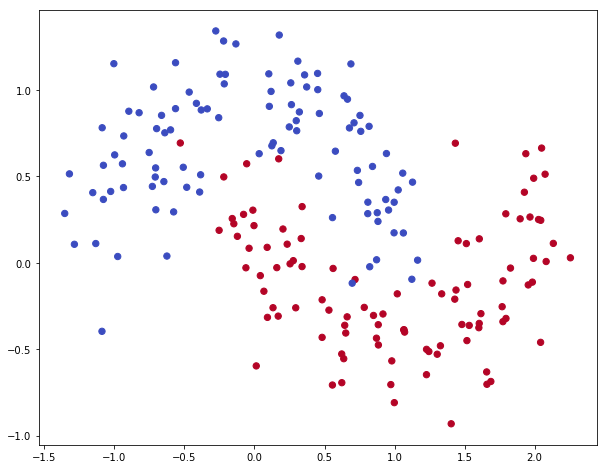

In [6]:
# Generate a dataset and plot it
np.random.seed(0)
X, Y = sklearn.datasets.make_moons(TRAINING_SIZE, noise=TRAINING_NOISE)
plt.scatter(X[:,0], X[:,1], s=40, c=Y, cmap=plt.cm.coolwarm)

In [7]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, Y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [8]:
def plot_decision_boundary(pred_func):
    """ from WildML
        @param pred_func is a prediction fct (i.e. logistic regression
            predictor, neural net, etc.)
        ->looks like must be np.array... check this out
        Effect: Plots decision bndry of prediction fct
            Colors plot space based on decision boundary"""
    # Set min and max values and give it some padding
    x_min, x_max = min(X[:, 0]) - .5, max(X[:, 0]) + .5
    y_min, y_max = min(X[:, 1]) - .5, max(X[:, 1]) + .5
    # apparently doing np.min/np.max will convert list to np array
    # first, so just using min/max is good enough
    
    # Generate grid of pts with dist h between
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    if(PRINT_DEBUG):print('The raveling of xx & yy:\n',np.c_[xx.ravel(),yy.ravel()])
    if(PRINT_DEBUG):print('Shape of np.c_ stuff:\n',shape(np.c_[xx.ravel(), yy.ravel()]))
    if(PRINT_DEBUG):print('What Z looks like:\n',Z)
    Z = Z.reshape(xx.shape)
    # so looks like input must be np.array stuff
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm)

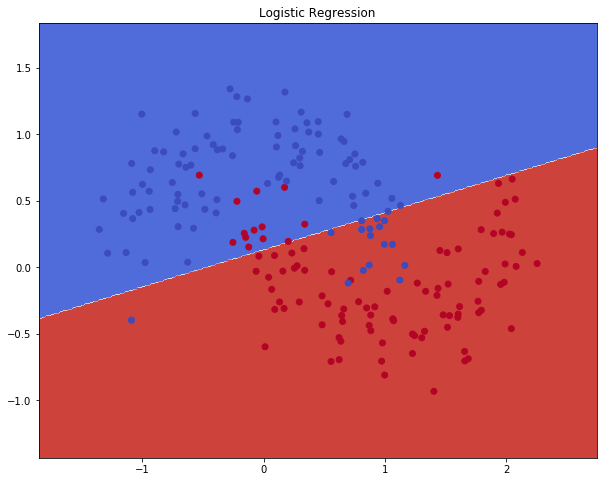

In [9]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

In [10]:
to_onehot   = {0:[1,0], 1:[0,1]}
from_onehotstr = {str([1,0]):0, str([0,1]):1}
Y_onehot = [to_onehot[k] for k in Y]

In [11]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [12]:
def inst_model(hidden_layers, x):
    """ @param hidden_layers is an array containing the sizes of subsequent
            hidden layers
        @param x is a placeholder representing input 
        Returns: output layer of basic feedforward neural network
        Precondition: each element of hidden_layers is positive integer"""
    num_hidds = len(hidden_layers)
    inc_dim = 2
    out_dim = 2
    if (num_hidds != 0):
        out_dim = hidden_layers[0]
    h = tf.matmul(x,weight_variable([inc_dim,out_dim])) + bias_variable([out_dim])
    if (num_hidds == 0):
        print('No dimensions passed...\nInstantiating random weights...')
        return h
    else:
        h = tf.nn.relu(h)
        for layer in arange(1, num_hidds):
            print('Instantiating random weights...')
            inc_dim = hidden_layers[layer-1]
            out_dim = hidden_layers[layer]
            h = tf.nn.relu(tf.matmul(h,weight_variable([inc_dim,out_dim])) + bias_variable([out_dim]))
        return tf.matmul(h,weight_variable([out_dim,2])) + bias_variable([2])

In [13]:
def build_model(hidden_layers, num_passes=20000, print_loss=False,
                sess=tf.InteractiveSession()):
    """ @param hidden_layers: numpy array containing the dimensions of all hidden layers
        N.B. that an empty array means no hidden layers
    @param num_passes: number of passes thru training data for gradient descent
    @param print_loss: If True, prints loss every 1000 iterations
    Effect: builds a neural net model based on architecture given in hidden_layers and by
        global variables for SPACE_DIM and NUM_CLASSES
        Then, it performs backprop for num_passes"""
    x = tf.placeholder(tf.float32, [None,2])
    y_out = inst_model(hidden_layers,x)
    y_true = tf.placeholder(tf.float32, [None, 2])
    cross_ent = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_out))
    train_step = tf.train.AdagradOptimizer(LEARN_RATE).minimize(cross_ent)
    correct_prediction = tf.equal(tf.argmax(y_out,1),tf.argmax(y_true,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    init = tf.global_variables_initializer()
    sess.run(init)
    for _ in range(20000):
        sess.run(train_step, feed_dict={x:X,y_true:Y_onehot})
        if(print_loss and (_+1)%1000==0):
            print('Accuracy after iteration {}: {}'.format(_+1,sess.run(accuracy,feed_dict={x:X,y_true:Y_onehot})))
    if(PRINT_DEBUG):print('y_out id: ',y_out)
    if(PRINT_DEBUG):print('x id: ',x)
    return y_out,x

In [14]:
def predictmod(model, x_id, X_data, sess=tf.InteractiveSession()):
    output = sess.run(model,feed_dict={x_id:X_data})
    if(PRINT_DEBUG):print('TF model: ',output)
    return np.argmax(output,axis=1)

In [15]:
test_sess = tf.InteractiveSession()
test_model,test_x = build_model([],print_loss=True,sess=test_sess)

No dimensions passed...
Instantiating random weights...
Accuracy after iteration 1000: 0.824999988079071
Accuracy after iteration 2000: 0.824999988079071
Accuracy after iteration 3000: 0.824999988079071
Accuracy after iteration 4000: 0.8299999833106995
Accuracy after iteration 5000: 0.8299999833106995
Accuracy after iteration 6000: 0.8299999833106995
Accuracy after iteration 7000: 0.8349999785423279
Accuracy after iteration 8000: 0.8349999785423279
Accuracy after iteration 9000: 0.8349999785423279
Accuracy after iteration 10000: 0.8299999833106995
Accuracy after iteration 11000: 0.8349999785423279
Accuracy after iteration 12000: 0.8399999737739563
Accuracy after iteration 13000: 0.8349999785423279
Accuracy after iteration 14000: 0.8349999785423279
Accuracy after iteration 15000: 0.8349999785423279
Accuracy after iteration 16000: 0.8349999785423279
Accuracy after iteration 17000: 0.8349999785423279
Accuracy after iteration 18000: 0.8349999785423279
Accuracy after iteration 19000: 0.8349

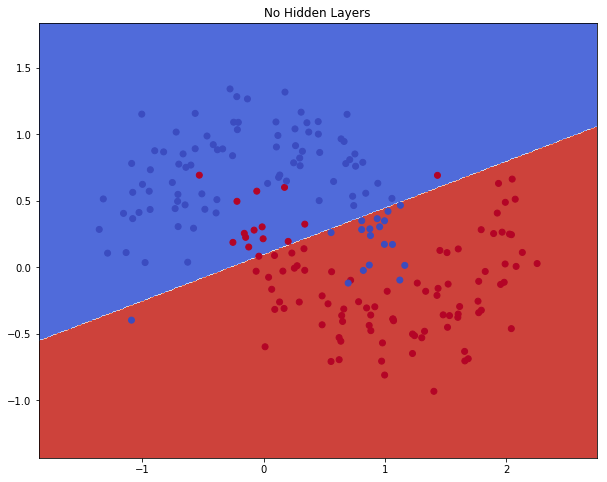

In [16]:
plot_decision_boundary(lambda x: predictmod(test_model, test_x, x, sess=test_sess))
plt.title("No Hidden Layers")

Instantiating random weights...
Instantiating random weights...
Accuracy after iteration 1000: 0.8650000095367432
Accuracy after iteration 2000: 0.9300000071525574
Accuracy after iteration 3000: 0.9750000238418579
Accuracy after iteration 4000: 0.9850000143051147
Accuracy after iteration 5000: 0.9800000190734863
Accuracy after iteration 6000: 0.9800000190734863
Accuracy after iteration 7000: 0.9800000190734863
Accuracy after iteration 8000: 0.9800000190734863
Accuracy after iteration 9000: 0.9800000190734863
Accuracy after iteration 10000: 0.9800000190734863
Accuracy after iteration 11000: 0.9800000190734863
Accuracy after iteration 12000: 0.9800000190734863
Accuracy after iteration 13000: 0.9700000286102295
Accuracy after iteration 14000: 0.9750000238418579
Accuracy after iteration 15000: 0.9750000238418579
Accuracy after iteration 16000: 0.9750000238418579
Accuracy after iteration 17000: 0.9750000238418579
Accuracy after iteration 18000: 0.9750000238418579
Accuracy after iteration 19

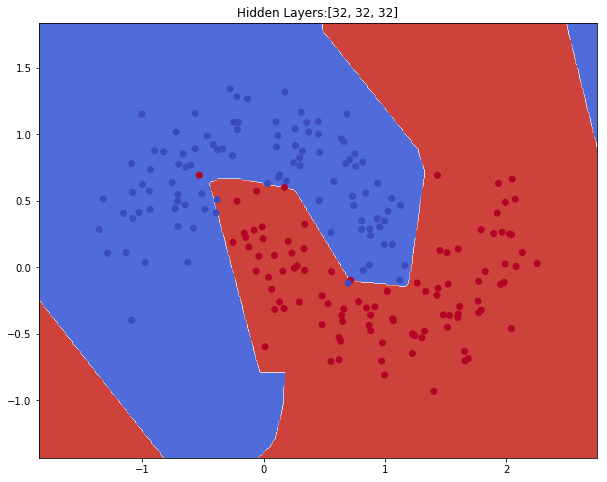

In [20]:
test_sess = tf.InteractiveSession()
test_model,test_x = build_model([32,32,32],print_loss=True,sess=test_sess)
plot_decision_boundary(lambda x: predictmod(test_model, test_x, x, sess=test_sess))
plt.title("Hidden Layers: "+str([32,32,32]))

Accuracy after iteration 1000: 0.8500000238418579
Accuracy after iteration 2000: 0.8500000238418579
Accuracy after iteration 3000: 0.8600000143051147
Accuracy after iteration 4000: 0.8700000047683716
Accuracy after iteration 5000: 0.8899999856948853
Accuracy after iteration 6000: 0.9300000071525574
Accuracy after iteration 7000: 0.9350000023841858
Accuracy after iteration 8000: 0.9350000023841858
Accuracy after iteration 9000: 0.9399999976158142
Accuracy after iteration 10000: 0.9449999928474426
Accuracy after iteration 11000: 0.9449999928474426
Accuracy after iteration 12000: 0.949999988079071
Accuracy after iteration 13000: 0.9549999833106995
Accuracy after iteration 14000: 0.9549999833106995
Accuracy after iteration 15000: 0.9599999785423279
Accuracy after iteration 16000: 0.9599999785423279
Accuracy after iteration 17000: 0.9599999785423279
Accuracy after iteration 18000: 0.9649999737739563
Accuracy after iteration 19000: 0.9649999737739563
Accuracy after iteration 20000: 0.9649999

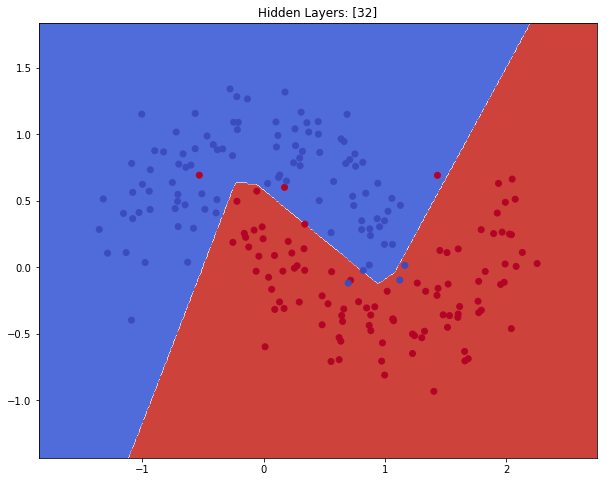

In [21]:
test_sess = tf.InteractiveSession()
test_model,test_x = build_model([32],print_loss=True,sess=test_sess)
plot_decision_boundary(lambda x: predictmod(test_model, test_x, x, sess=test_sess))
plt.title("Hidden Layers: "+str([32]))

Accuracy after iteration 1000: 0.925000011920929
Accuracy after iteration 2000: 0.9399999976158142
Accuracy after iteration 3000: 0.9449999928474426
Accuracy after iteration 4000: 0.9549999833106995
Accuracy after iteration 5000: 0.9599999785423279
Accuracy after iteration 6000: 0.9649999737739563
Accuracy after iteration 7000: 0.9700000286102295
Accuracy after iteration 8000: 0.9700000286102295
Accuracy after iteration 9000: 0.9750000238418579
Accuracy after iteration 10000: 0.9750000238418579
Accuracy after iteration 11000: 0.9850000143051147
Accuracy after iteration 12000: 0.9850000143051147
Accuracy after iteration 13000: 0.9850000143051147
Accuracy after iteration 14000: 0.9850000143051147
Accuracy after iteration 15000: 0.9850000143051147
Accuracy after iteration 16000: 0.9850000143051147
Accuracy after iteration 17000: 0.9850000143051147
Accuracy after iteration 18000: 0.9850000143051147
Accuracy after iteration 19000: 0.9850000143051147
Accuracy after iteration 20000: 0.9850000

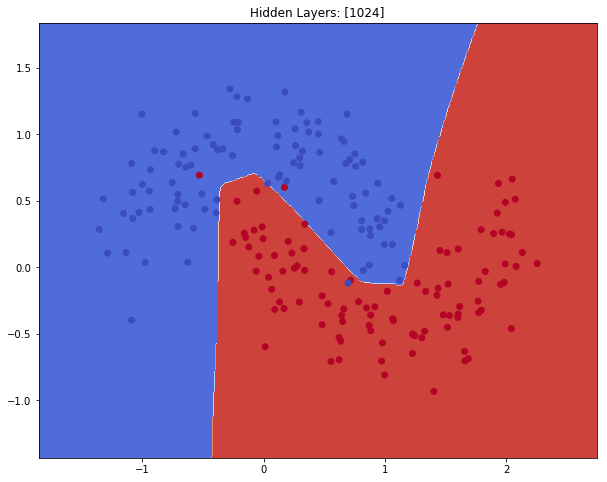

In [22]:
test_sess = tf.InteractiveSession()
test_model,test_x = build_model([1024],print_loss=True,sess=test_sess)
plot_decision_boundary(lambda x: predictmod(test_model, test_x, x, sess=test_sess))
plt.title("Hidden Layers: "+str([1024]))

Instantiating random weights...
Instantiating random weights...
Accuracy after iteration 1000: 0.9350000023841858
Accuracy after iteration 2000: 0.9700000286102295
Accuracy after iteration 3000: 0.9850000143051147
Accuracy after iteration 4000: 0.9800000190734863
Accuracy after iteration 5000: 0.9800000190734863
Accuracy after iteration 6000: 0.9800000190734863
Accuracy after iteration 7000: 0.9750000238418579
Accuracy after iteration 8000: 0.9800000190734863
Accuracy after iteration 9000: 0.9800000190734863
Accuracy after iteration 10000: 0.9800000190734863
Accuracy after iteration 11000: 0.9850000143051147
Accuracy after iteration 12000: 0.9850000143051147
Accuracy after iteration 13000: 0.9850000143051147
Accuracy after iteration 14000: 0.9850000143051147
Accuracy after iteration 15000: 0.9900000095367432
Accuracy after iteration 16000: 0.9900000095367432
Accuracy after iteration 17000: 0.9900000095367432
Accuracy after iteration 18000: 0.9900000095367432
Accuracy after iteration 19

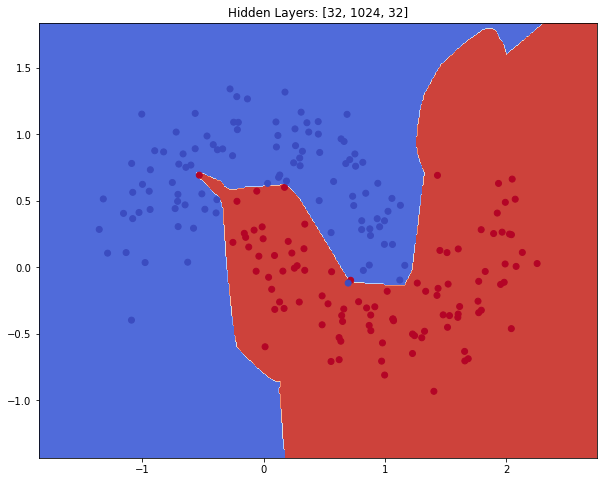

In [23]:
test_sess = tf.InteractiveSession()
test_model,test_x = build_model([32,1024,32],print_loss=True,sess=test_sess)
plot_decision_boundary(lambda x: predictmod(test_model, test_x, x, sess=test_sess))
plt.title("Hidden Layers: "+str([32,1024,32]))